# (SSS) Size-Spectral Slope at 100m and at the surface 
* log(abs) vs log(volume) annually

**** new approach ****

Before this, I would exclude the diazotrophs from this trend becuase they are not found in the Arctic, so they show up as a nan value that creates the whole regression a nan for the Arctic. By taking them out, we solve that problem completely, but that affected the slope of regions that did not have diazotrophs, and any other group that was not found in any other region.. 

SO.... I think I finally figured it out. I instead of making them into nan's I made them into Zeros, and instead of taking just the regular log10, I added a 1 to all of the values so if there are values that are zero's they do not affect the slopes and they just become zeros after the log. 

This solved the problem of having ot have a mask for the diazotrophs, and the slopes look a lot more like they should be looking. 

In [36]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
import os
import matplotlib.gridspec as gridspec

In [37]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs

import geoviews as gv
import holoviews as hv
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import matplotlib as mpl

In [38]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [39]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## input file

In [40]:
## print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

 GNG595


What year? (year)


 20yrclim


In [41]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path 
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
new_path = '/glade/scratch/jluo/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

newNCDFfiles = sorted(glob.glob(''+gabyn_path+new_file+'/ocn/hist/'+path_file+new_file+'.pop.h.00'+year+'-*.nc', recursive=True),
                      key=numericalSort)

In [42]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim/*', recursive=True),
                      key=numericalSort)

In [43]:
ds = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

## Import the abundance  and volume of the community 
* Units for pytoplankton: 
    * $volume$ [$um^3$]
* Units for zooplankton 
    * $volume$ [$m^3$] converted to [$um^3$] by multiplying by [$10^9$]

In [44]:
## Gaby's Path 
gabyn_path = '/glade/u/home/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+new_file+'/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mass_ugC') # sorting sizes by mass in ugC 
sizes

,type,sname,mass_ugC,vol_um3,ESD_mm,Qp_fixed,mmolC
1,phyto,pp,9.266989e-08,3.706795e-01,0.000891,0.004651,7.715418e-12
2,phyto,mp1,8.241979e-06,1.805089e+01,0.003255,0.006824,6.862025e-10
0,phyto,diaz,5.499929e-05,1.227865e+02,0.006167,0.003333,4.579077e-09
3,phyto,mp2,8.888712e-05,8.790197e+02,0.011885,0.008656,7.400476e-09
6,phyto,diat1,5.004513e-04,1.327390e+04,0.029376,0.010289,4.166608e-08
9,zoo,zoo1,2.803686e-03,2.355042e+04,0.035563,0.008547,2.334265e-07
7,phyto,diat2,3.803133e-03,1.326626e+05,0.063278,0.012602,3.166375e-07
4,phyto,mp3,4.830334e-03,4.280541e+04,0.043401,0.012907,4.021592e-07
8,phyto,diat3,2.890156e-02,1.325863e+06,0.136301,0.015435,2.406258e-06
10,zoo,zoo2,8.933984e-02,7.447577e+05,0.112462,0.008547,7.438168e-06


In [45]:
# Sorting mass and names of only the phytoplankton by mass. 
phyto_mass = array([sizes.mass_ugC[1],sizes.mass_ugC[2],sizes.mass_ugC[0],sizes.mass_ugC[3],
                   sizes.mass_ugC[6],sizes.mass_ugC[7],sizes.mass_ugC[4],sizes.mass_ugC[8],
                   sizes.mass_ugC[5]])

phyto_vol = array([sizes.vol_um3[1],sizes.vol_um3[2],sizes.vol_um3[0],sizes.vol_um3[3],
                   sizes.vol_um3[6],sizes.vol_um3[7],sizes.vol_um3[4],sizes.vol_um3[8],
                   sizes.vol_um3[5]]) # units of um^3 (this is good). 

phyto_names = array([sizes.sname[1],sizes.sname[2],sizes.sname[0],sizes.sname[3],
                   sizes.sname[6],sizes.sname[7],sizes.sname[4],sizes.sname[8],
                   sizes.sname[5]])

## volume 
# units [um^3]
pp_v = 0.195428825646897
mp1_v = 37.6111075368976
diaz_v = 122.786536059293
diat1_v = 4187.92236603257
mp2_v = 7238.41739042113
diat2_v = 374617.983936749
mp3_v = 1393064.17037973
diat3_v = 33510323.645704
mp4_v = 268101116.324664

# units [mm^3] into [um^3]
zoo1_v = 5.23598775598299E-07 * 1e9
zoo2_v = 5.00745000930114E-05 * 1e9
zoo3_v = 0.00478888736265629 * 1e9
zoo4_v = 0.457986442792462 * 1e9
zoo5_v = 43.7996482058306 * 1e9
zoo6_v = 4188.79033024969 * 1e9

phyto_vol = array([pp_v,mp1_v, diaz_v, diat1_v,mp2_v,diat2_v,mp3_v,diat3_v,mp4_v])
zoo_vol = array([zoo1_v, zoo2_v, zoo3_v, zoo4_v, zoo5_v, zoo6_v])

## Mass
# units [ug C]
pp_m = 4.88572064117242E-08
mp1_m = 1.70475047067261E-05
diaz_m = 5.49992918958176E-05
diat1_m = 0.000181125995838518
mp2_m = 0.000910343637769569
diat2_m = 0.00949142840730853
mp3_m = 0.127112682492814
diat3_m = 0.497373183755356
mp4_m = 17.7489393896427

# units [mg C] to [ug C]
zoo1_m = 7.86253129691093E-08 * 1000
zoo2_m = 5.69328191250882E-06 * 1000
zoo3_m = 0.000574466613113713 * 1000
zoo4_m = 0.0549392584788313 * 1000
zoo5_m = 5.25412974975864 * 1000
zoo6_m = 502.48001505036 * 1000

phyto_mass = array([pp_m,mp1_m, diaz_m, diat1_m,mp2_m,diat2_m,mp3_m,diat3_m,mp4_m])
zoo_mass = array([zoo1_m, zoo2_m, zoo3_m, zoo4_m, zoo5_m, zoo6_m])

In [46]:
#phyto_names = ['pp','mp1','diaz','diat1','mp2','diat2','mp3','diat1','mp4']
phyto_vars = [v+'C' for v in phyto_names]
phyto_bmss = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol m-3
phyto_bmss = phyto_bmss[:,:,1,:,:]*10/15 # units are mmol m^-3
phyto_bmss = phyto_bmss * 12.011 *1000 # ug C m-3

In [47]:
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
zoo_vars = [v+'C' for v in zoo_names]
zoo_bmss = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol m-3
zoo_bmss = zoo_bmss[:,:,1,:,:]*10/15 # units are mmol m^-3
zoo_bmss = zoo_bmss * 12.011 *1000 # ug C m^-3

## Abundance 

In [48]:
phyto_abu = np.zeros((9,12,384,320))
for i in range(9):
    phyto_abu[i,:,:,:] = phyto_bmss[i,:,:,:]/phyto_mass[i]
    
zoo_abu = np.zeros((6,12,384,320))
for j in range(6):
    zoo_abu[j,:,:,:] = zoo_bmss[j,:,:,:]/zoo_mass[j]

In [49]:
# log of volumes for phytoplankton, zooplankton and both. 
xp = np.log10(phyto_vol+1)

# Make the zero's into NaNs 
phyto_abu[phyto_abu<0] = 0

# abundance for phyto
phyto_abu = np.log10(phyto_abu[:,:,:,:]+1)
#yp_surface = np.log10(phy_abundance[:,:,1,:,:]+1)
#yp_100m    = np.log10(phy_abundance[:,:,10,:,:]+1)

# the size of 1,474,560
n = 12*384*320

# reshape the 4-D array to a 2-D array. 
yp_reshape = phyto_abu.reshape((9, n))

# create the calculation 
yp_results = np.empty((n, 5))

for i in range(n):
    yp_results[i] = stats.linregress(xp, yp_reshape[:,i])
    
# reshape back to size wanted. back to 4D, but the 5 is where the slope, interecpt, etc. are. 
ypp_surface = yp_results.reshape((12,384,320, 5)) 

In [50]:
ypp_surface[ypp_surface==0]=np.nan

## Winter, Spring, Summer and Fall. 

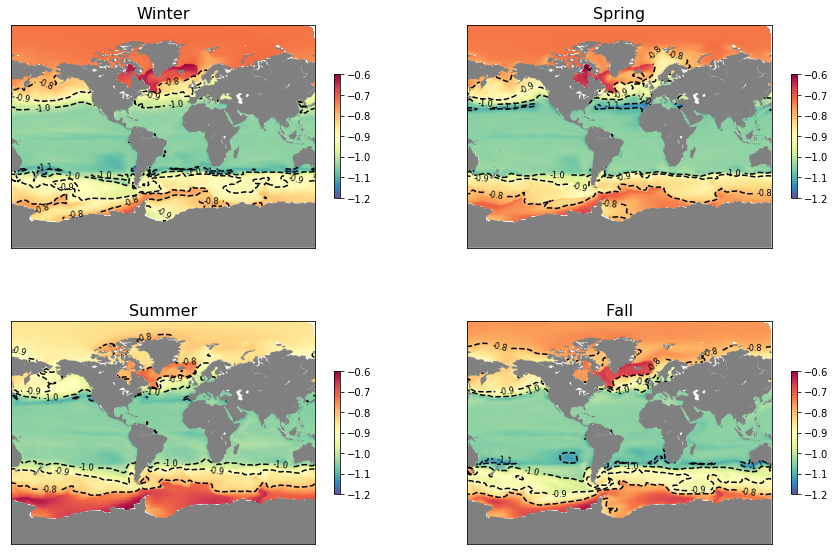

In [51]:
fig = plt.figure(figsize=(12, 10))
lat = ds.TLAT[:,1]

## WINTER 
ax = fig.add_subplot(2, 2, 1)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[list(range(2)) + [-1],:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = -1.2, vmax = -0.6)
cs = m.contour(x, y, winter,levels = [-1.2, -1.1, -1,-0.9, -0.8, -0.6],colors='k')
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform')
ax.set_title('Winter', fontsize =16)

## SPRING
ax = fig.add_subplot(2, 2, 2)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, spring = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[2:5,:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,spring,cmap='Spectral_r', vmin = -1.2, vmax = -0.6)
cs = m.contour(x, y, spring,levels = [-1.2, -1.1, -1,-0.9, -0.8, -0.6],colors='k')
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform')
ax.set_title('Spring', fontsize =16)

## SUMMER
ax = fig.add_subplot(2, 2, 3)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[5:8,:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,summer,cmap='Spectral_r', vmin = -1.2, vmax = -0.6)
cs = m.contour(x, y, summer,levels = [-1.2, -1.1, -1,-0.9, -0.8, -0.6],colors='k')
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform')
ax.set_title('Summer', fontsize =16)


##FALL
ax = fig.add_subplot(2, 2, 4)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, fall = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[8:11,:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,fall,cmap='Spectral_r', vmin = -1.2, vmax = -0.6)
cs = m.contour(x, y, fall,levels = [-1.2, -1.1, -1,-0.9, -0.8, -0.6],colors='k')
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cbar = fig.colorbar(cf, cmap='Spectral_r',shrink=0.5, spacing='uniform')
ax.set_title('Fall', fontsize =16);
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/SSS_surf_seasonal_global_'+year+'year.png', dpi=600, bbox_inches='tight')

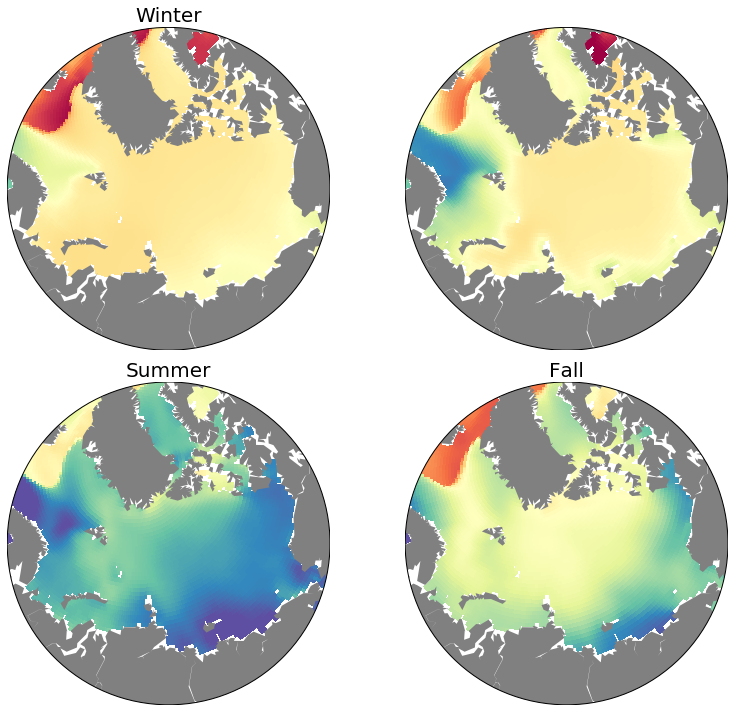

In [59]:
fig = plt.figure(figsize=(12, 10))
lat = ds.TLAT[:,1]

## WINTER 
ax = fig.add_subplot(2, 2, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[list(range(2)) + [-1],:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,winter,cmap='Spectral_r', vmin = -0.9, vmax = -0.6)
ax.set_title('Winter', fontsize =20)

## SPRING
ax = fig.add_subplot(2, 2, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, spring = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[2:5,:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,spring,cmap='Spectral_r', vmin = -0.9, vmax = -0.6)
#ax.set_title('Spring', fontsize =20)

## SUMMER
ax = fig.add_subplot(2, 2, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[5:8,:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,summer,cmap='Spectral_r', vmin = -0.9, vmax = -0.6)
ax.set_title('Summer', fontsize =20)


##FALL
ax = fig.add_subplot(2, 2, 4)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, fall = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[8:11,:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,fall,cmap='Spectral_r', vmin = -0.9, vmax = -0.6)
ax.set_title('Fall', fontsize =20);
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/AO/SSS_surf_seasonal_ao_'+year+'year.png', dpi=600, bbox_inches='tight')

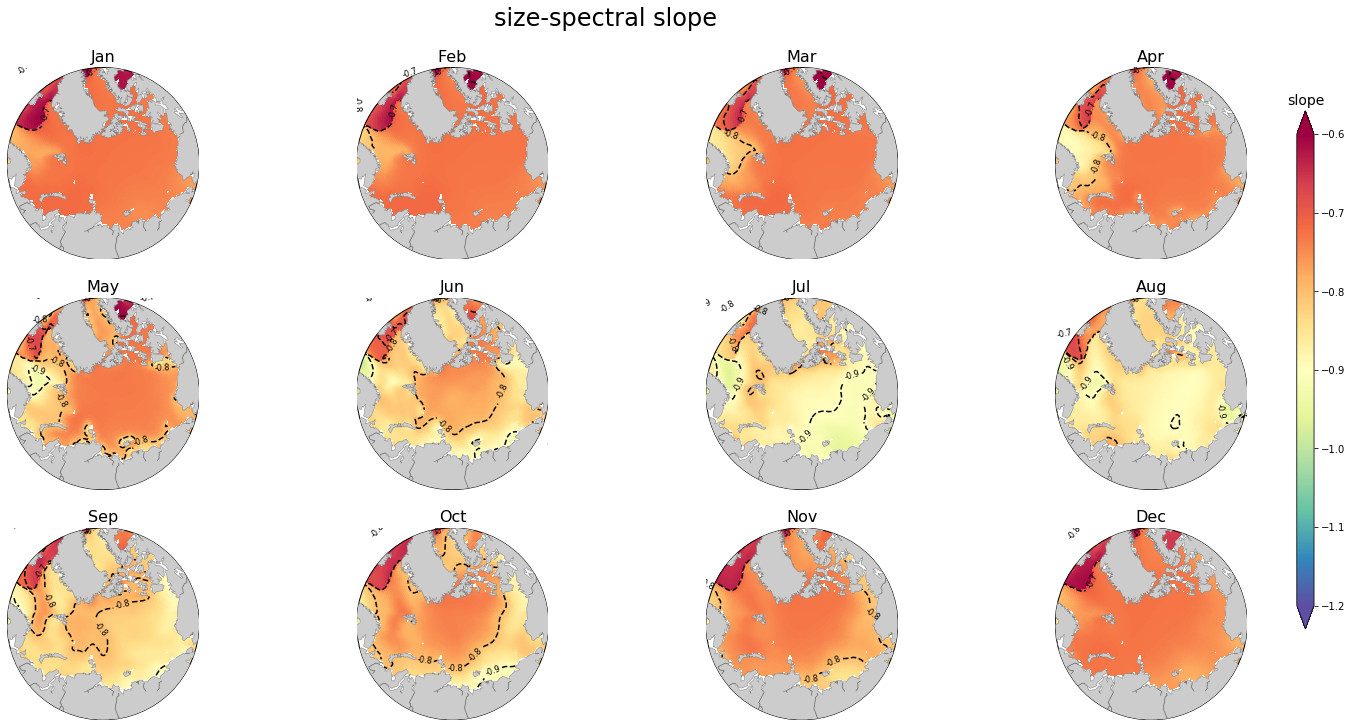

In [53]:
ypp_surface[ypp_surface==0]=np.nan

fig = plt.figure(figsize=(24, 12))

# month names 
phyto_names = ['Jan', 'Feb','Mar','Apr',
              'May','Jun','Jul','Aug',
              'Sep','Oct','Nov','Dec']

m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')

for i in range(1,13):
    ax = fig.add_subplot(3, 4, i)
    tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[i-1,:,:,0])
    x,y = m(tlon, tlat)
    cf = m.pcolor(x,y,phyto,cmap='Spectral_r', vmin = -1.2, vmax = -0.6)
    cs=m.contour(x, y, phyto, levels =[-1.2,-1, -0.9,-0.8,-0.7, -0.6, -0.4],colors='k')
    plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
    m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
    m.fillcontinents(color='0.8', lake_color=None, ax=None, zorder=None, alpha=None)
    ax.set_title(''+str(phyto_names[i-1]), fontsize = 16)
    
cb_ax = fig.add_axes([0.9, 0.23, 0.01, 0.6])
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1.2, vmax=-0.6), 
                                      cmap='Spectral_r'),cax=cb_ax, extend = 'both')
cbar.ax.set_title('slope', fontsize = 14)
    
fig.suptitle('size-spectral slope', x=0.5, y=.95,fontsize=24)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/SSS_monthly_surface_ao_'+year+'year.png', dpi=300, bbox_inches='tight')

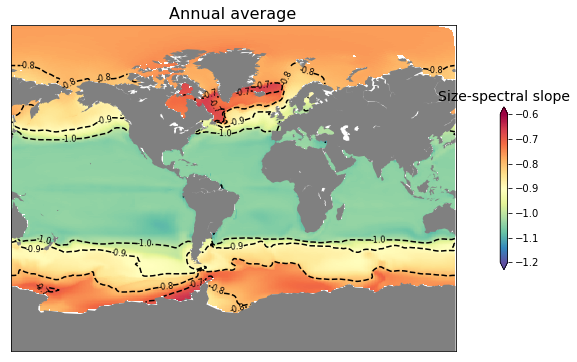

In [54]:
# this creates all zero slopes into a nan. 
ypp_surface[ypp_surface==0]=np.nan

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[:,:,:,0].mean(axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,phyto,cmap='Spectral_r', vmin = -1.2, vmax = -0.6)
cs = m.contour(x, y, phyto,levels = [-1.2,-1.1, -1,-0.9, -0.8,-0.7, -0.6],colors='k')
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, extend ='both')
cb.ax.set_title('Size-spectral slope', fontsize=14)
ax.set_title('Annual average', fontsize = 16);

# save the figure 
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/SSS_surf_annual_'+year+'year.png', dpi=600, bbox_inches='tight')

import scipy.io as sio
sio.savemat('size_spectral_slope_surface.mat',{'phyto_regression_surface':ypp_surface, 
                                               'phyto_regression_100m':ypp_100m})

In [55]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [56]:
#lev = [-1.2,-1.1, -1,-0.9, -0.8,-0.7, -0.6]
lev = np.arange(-0.9, -0.6, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=-0.8)
ypp_surface[ypp_surface==0]=np.nan

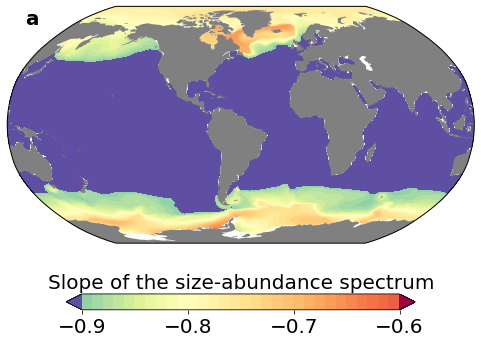

In [57]:
fig = plt.figure(figsize=(10, 5))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, ypp_surface[:,:,:,0].mean(axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon, tlat, phyto, vmin=-1.0, vmax=-0.5,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
#cs = ax.contour(x, y, phyto, colors='k', levels=lev, linewidths=0.5,transform=ccrs.PlateCarree())
#lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%r');
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-1.0,-0.9, -0.8,-0.7,-0.6,-0.5],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('Slope of the size-abundance spectrum', fontsize=20)
fig.text(0.20, 0.92, 'a',fontsize=20, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/AO/SSS_surf_annual_'+year+'year.png', dpi=600, bbox_inches='tight')